> # Abstract

Motion detect can be a challenging task in case if:

* Low resolution video
* Unstable RTSP connection
* dropped UDP packets

So, some frames from surveilance cameras can be lost and, therefore video stream can be distored.
In such cases general motion detect algorithms can produce false positive signals.

We consider next popular background removal algorithms that has implementations for many libraries and languages, e.g, pyhton OpenCV, etc.:

* MOG (Mixture of Gausiian)
* KNN (K-Nearest Neighbors)

Let's consider a small video and try to extract signal that describes if any motion on video detected.

# Example 

You can download example video [here](https://github.com/onidzelskyi/motion_detect_low_resolution_cameras/blob/main/data/sample_1.mp4) or use your own data to check main idea.

# Import

In [99]:
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import signal

import matplotlib.pyplot as plt
%matplotlib inline

# Variables

In [100]:
video_file = 'motion_detect_low_resolution_cameras/data/sample_1.mp4'

# Get sample data

In [101]:
%%bash

URL=https://github.com/onidzelskyi/motion_detect_low_resolution_cameras.git
FOLDER=motion_detect_low_resolution_cameras

if [ ! -d "$FOLDER" ] ; then
    git clone $URL $FOLDER
else
    cd "$FOLDER"
    git pull $URL
fi

Cloning into 'motion_detect_low_resolution_cameras'...


In [102]:
!ls -lat motion_detect_low_resolution_cameras/data

total 12840
-rw-r--r--  1 oleksiinidzelskyi  staff  6571986 Feb 16 21:24 sample_1.mp4
drwxr-xr-x  3 oleksiinidzelskyi  staff       96 Feb 16 21:24 .
drwxr-xr-x  7 oleksiinidzelskyi  staff      224 Feb 16 21:24 ..


# Get video properties

In [103]:
capture = cv.VideoCapture(video_file)
print(f'FPS: {capture.get(cv.CAP_PROP_FPS)}')
print(f'Start offset: {capture.get(cv.CAP_PROP_POS_FRAMES)}')
print(f'Total frames: {int(capture.get(cv.CAP_PROP_FRAME_COUNT))}')
print(f'Total seconds: {int(capture.get(cv.CAP_PROP_FRAME_COUNT) / (capture.get(cv.CAP_PROP_FPS)))}')


FPS: 12.0
Start offset: 0.0
Total frames: 996
Total seconds: 83


In [104]:
# Create background subtractor
backSub = cv.createBackgroundSubtractorKNN()

fgMask = None
masks = []

with tqdm(total=capture.get(cv.CAP_PROP_FRAME_COUNT)) as pbar:
    while True:
        ret, frame = capture.read()
    
        if frame is None:
            break

        pbar.update(1)
    
        fgMask = backSub.apply(frame)
        
        masks.append(fgMask[fgMask > 0].shape[0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 996/996.0 [00:06<00:00, 147.65it/s]


# Create dataframe from collected results

In [105]:
df = pd.DataFrame({'signal': masks})

# Display results

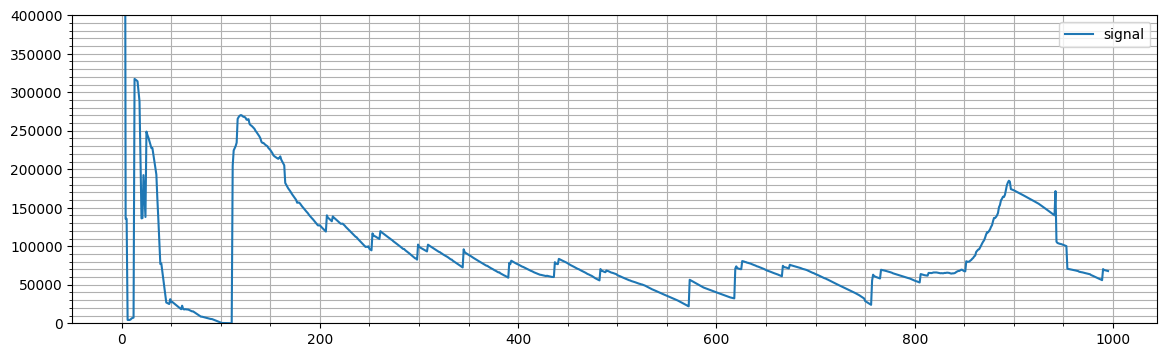

In [106]:
ax = df.plot(figsize=(14, 4))
ax.grid(axis='both', which='both')
plt.minorticks_on()
plt.ylim([0, 400000])
plt.show()

# Result

As we can see the signal line is a bit hectic and it's hard to say which peaks corresponds to real motion detect.
Moreover, some high peask are distoritions between frames in input video so this signal plot has no value to make a decision.

# Filter approach

To overcome this task let's try several filter techniques, such as:

* Blur
* MedianBlur
* Bilateral
* Gaussian

Below demonstrated samples for each filter for small area from random frame

Text(0.5, 1.0, 'median')

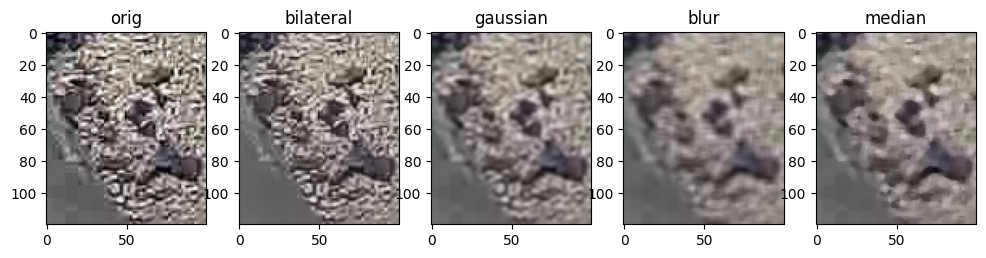

In [107]:
capture = cv.VideoCapture(video_file)
new_pos = 80 #* capture.get(cv.CAP_PROP_FPS)
capture.set(cv.CAP_PROP_POS_FRAMES, new_pos)
ret, frame = capture.read()
sigma = 1 << 5
box = frame[600:, 300:400, :]
box_filtered = cv.bilateralFilter(box, sigma, sigma * 2, sigma / 2)
gaussian_frame = cv.GaussianBlur(box, (5, 5), 0)
blur_frame = cv.blur(box, (5, 5))
median_blur_frame = cv.medianBlur(box, 5)

f, axarr = plt.subplots(1,5, figsize=(12,4)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(box)
axarr[0].set_title('orig')
axarr[1].imshow(box_filtered)
axarr[1].set_title('bilateral')
axarr[2].imshow(gaussian_frame)
axarr[2].set_title('gaussian')
axarr[3].imshow(blur_frame)
axarr[3].set_title('blur')
axarr[4].imshow(median_blur_frame)
axarr[4].set_title('median')


# Compare filters

Let's compare signal lines for aforementioned filters with original signal.
For this let's apply background removal for each frame filtered by them.

In [108]:
origin = lambda x: x
bilateral = lambda x, sigma=1<<5: cv.bilateralFilter(x, sigma, sigma * 2, sigma / 2)
gaussian = lambda x: cv.GaussianBlur(x, (5, 5), 0)
blur = lambda x: cv.blur(frame, (5, 5))
median = lambda x: cv.medianBlur(frame, 5)

filters = {
    'original': {'filter': origin, 'subtractor': cv.createBackgroundSubtractorKNN(), 'signal': []},
    'bilateral': {'filter': bilateral, 'subtractor': cv.createBackgroundSubtractorKNN(), 'signal': []},
    'blur': {'filter': blur, 'subtractor': cv.createBackgroundSubtractorKNN(), 'signal': []},
    'gaussian': {'filter': gaussian, 'subtractor': cv.createBackgroundSubtractorKNN(), 'signal': []},
    'median': {'filter': median, 'subtractor': cv.createBackgroundSubtractorKNN(), 'signal': []},
}

capture = cv.VideoCapture(video_file)
with tqdm(total=capture.get(cv.CAP_PROP_FRAME_COUNT)) as pbar:
    while True:
        # Read frame
        ret, frame = capture.read()
    
        # EOF
        if frame is None:
            break
        pbar.update(1)
    
        for filter_name in filters:
            filtered_frame = filters[filter_name]['filter'](frame)
            mask = filters[filter_name]['subtractor'].apply(filtered_frame)
            filters[filter_name]['signal'].append(mask[mask > 0].shape[0])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 996/996.0 [01:46<00:00,  9.38it/s]


# Display results

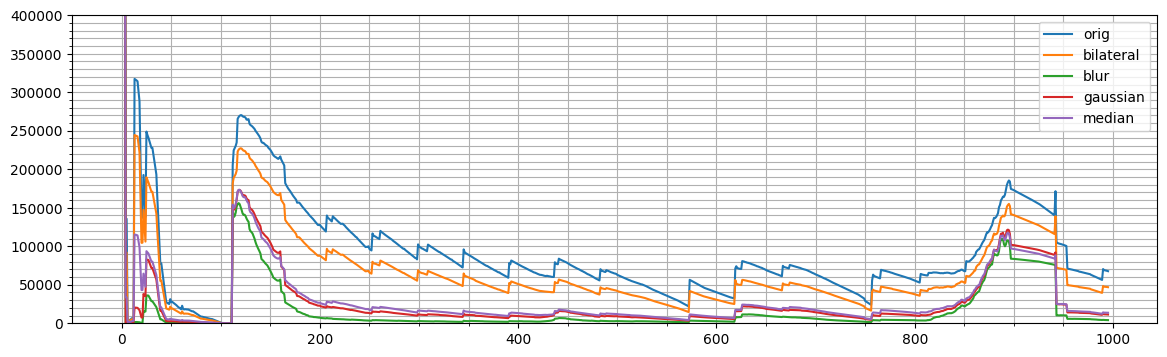

In [109]:
df = pd.DataFrame({
    'orig': filters['original']['signal'],
    'bilateral': filters['bilateral']['signal'],
    'blur': filters['blur']['signal'],
    'gaussian': filters['gaussian']['signal'],
    'median': filters['median']['signal'],
})

ax = df.plot(figsize=(14, 4))
ax.grid(axis='both', which='both')
plt.minorticks_on()
plt.ylim([0, 400000])
plt.show()

# Results 1

As we can see some filters not mitigate distortions in output signal (**bilateral** for example).

And others, such as **blur** makes output signal smooth enough for further motion detect analysis.

So, let's assume that as a filter we'll use **blur** filter.


# Kalman filter


Obviously next step for output signal is to apply **Kalman** filter for it.

The main purpose is to remove noise from input signal.

Let's apply **Kalman** filer to our signal and plot results.

In [110]:
# Kalman
kalman_arr = []
kalman = cv.KalmanFilter(2, 1)
kalman.measurementMatrix = np.array([[1, 0]], np.float32)
kalman.transitionMatrix = np.array([[1, 0], [0, 1]], np.float32)
kalman.processNoiseCov = np.array([[1, 0], [0, 1]], np.float32) * 0.03

# Add kalman data storage
filters.update({
    'kalman': {'filter': None, 'subtractor': None, 'signal': []},
})
# Reset blur filter data storage
filters['blur']['signal'] = []

capture = cv.VideoCapture(video_file)

with tqdm(total=capture.get(cv.CAP_PROP_FRAME_COUNT)) as pbar:
    while True:
        # Read frame
        ret, frame = capture.read()
    
        # EOF
        if frame is None:
            break
        pbar.update(1)
    
        filtered_frame = filters['blur']['filter'](frame)
        mask = filters[filter_name]['subtractor'].apply(filtered_frame)
        filters['blur']['signal'].append(mask[mask > 0].shape[0])

        measurement = np.array([np.float32(mask[mask > 0].shape[0])])

        kalman.correct(measurement)
        prediction = kalman.predict()
        filters['kalman']['signal'].append(prediction[0][0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 996/996.0 [00:04<00:00, 220.95it/s]


# Display results

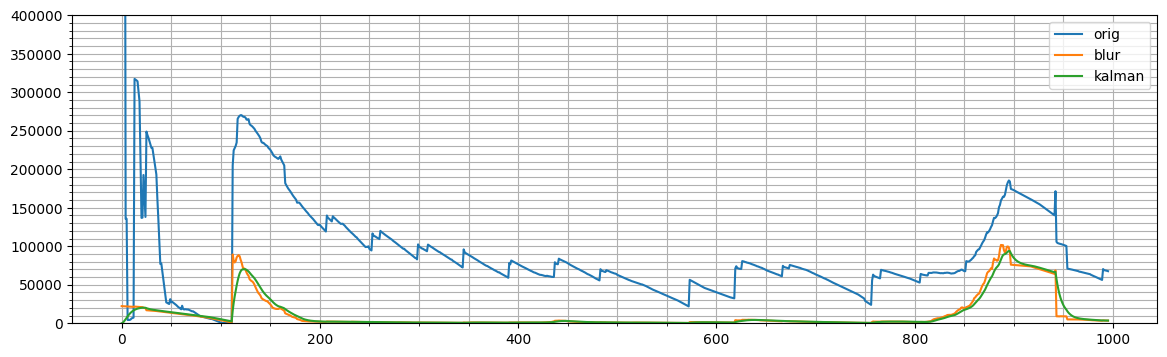

In [111]:
df = pd.DataFrame({
    'orig': filters['original']['signal'],
    'blur': filters['blur']['signal'],
    'kalman': filters['kalman']['signal'],
})

ax = df.plot(figsize=(14, 4))
ax.grid(axis='both', which='both')
plt.minorticks_on()
plt.ylim([0, 400000])
plt.show()

# Results 2

As we can see from the plot above output signal after next transformations:

* Blur
* Kalman 


is quite smooth and can be used for motion detect algorithm.


# Check out motion detect

The easiest way to check out if we correctly detected events when smth happens on FOV (Field Of View) 
let's display edge images for each time gap.

In our case time gaps (frame count) are:

* 110 - 160
* 850- 940

So, let's display a random snapshot from time gaps above:

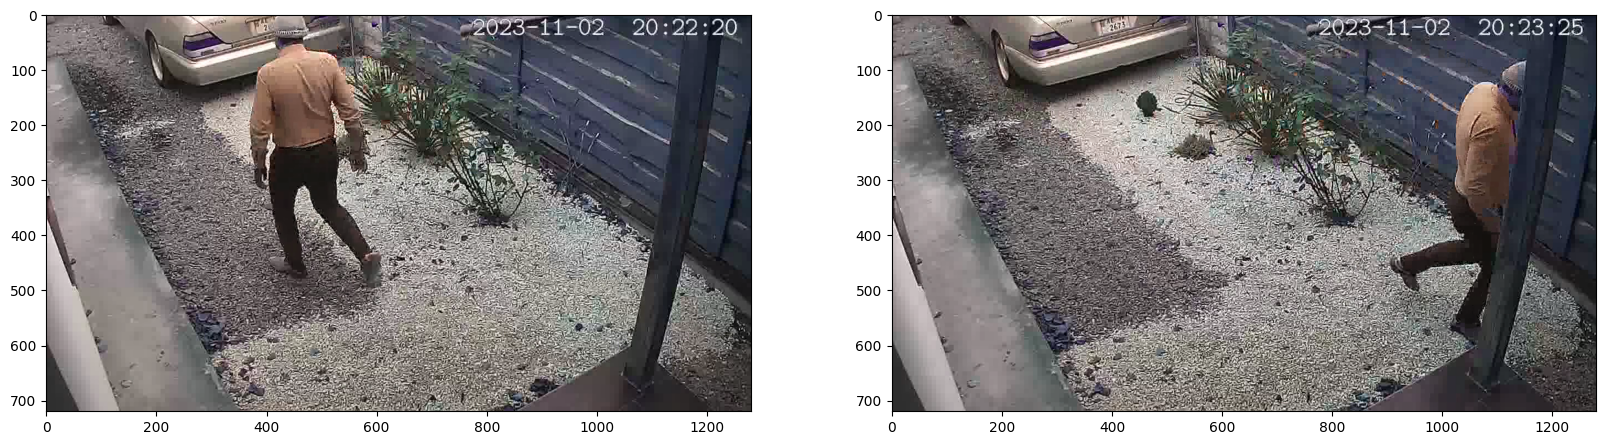

In [112]:
capture = cv.VideoCapture(video_file)

motion_1, motion_2 = 120, 900

capture.set(cv.CAP_PROP_POS_FRAMES, motion_1)
ret, motion_1_frame = capture.read()

capture.set(cv.CAP_PROP_POS_FRAMES, motion_2)
ret, motion_2_frame = capture.read()

f, axarr = plt.subplots(1,2, figsize=(20,8)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(motion_1_frame)
axarr[1].imshow(motion_2_frame)

# Results 3

As we can see from snapshots above proposed method of filtering input signal with consequitive applying of **Kalman** fiter is the viable 
and we achieve a good results.


# Peaks

Last one but not least thing is to automate our process of finding and displaying time slices with motion events on the video.


(0.0, 100000.0)

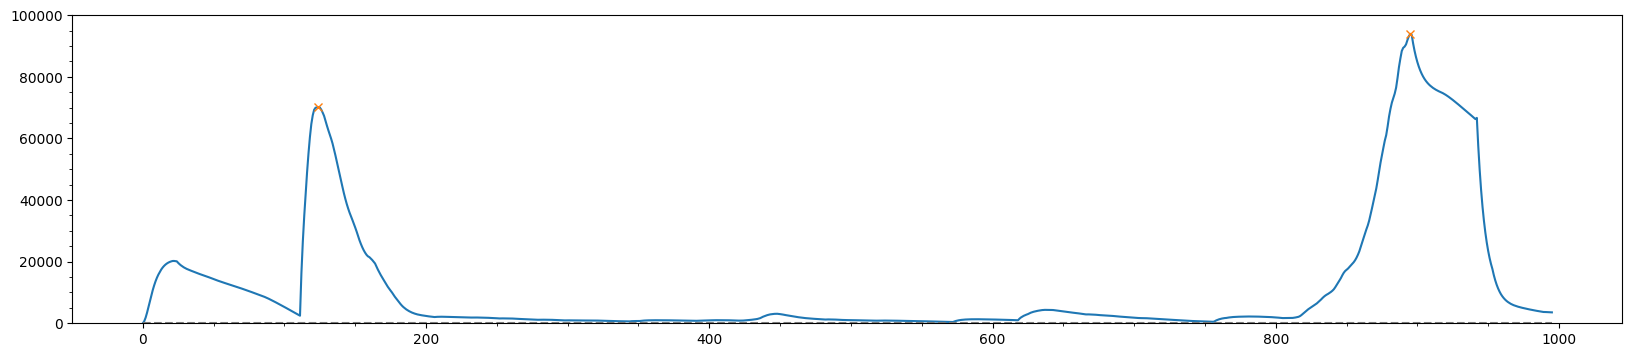

In [113]:
y_coordinates = np.array(df.kalman.values) # convert your 1-D array to a numpy array if it's not, otherwise omit this line

peaks, _ = signal.find_peaks(y_coordinates, height=7e+4)
plt.figure(figsize=(20, 4))
plt.plot(y_coordinates)
plt.plot(peaks, y_coordinates[peaks], "x")
plt.plot(np.zeros_like(y_coordinates), "--", color="gray")
plt.minorticks_on()
plt.ylim([0, 100000])

Motion 1: frame 124
Motion 2: frame 895


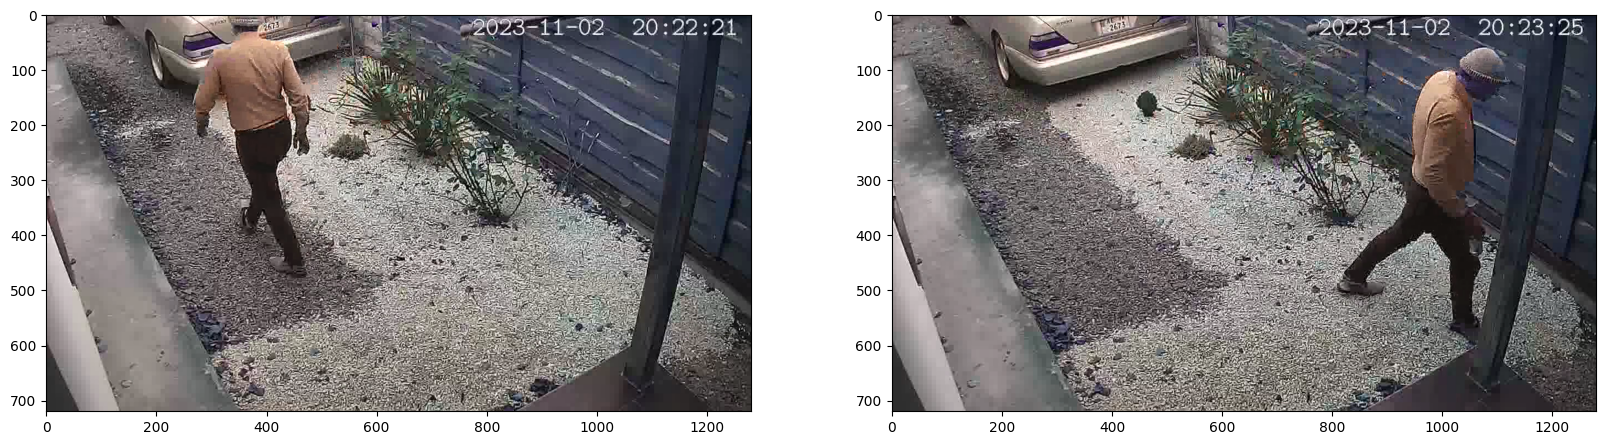

In [114]:
capture = cv.VideoCapture(video_file)

motions_num = peaks.size
f, axarr = plt.subplots(1, motions_num, figsize=(20,8)) 

for i, motion_offset in enumerate(peaks.tolist()):
    print(f'Motion {i+1}: frame {motion_offset}')
    capture.set(cv.CAP_PROP_POS_FRAMES, motion_offset)
    ret, motion_frame = capture.read()
    axarr[i].imshow(motion_frame)


# **Conclusion:**

We evaluated a fully automated, end-to-end pipeline for motion detection in low-resolution surveillance IP cameras. While this method achieved an accurate results on a standard dataset of sample videos, further refinement may be needed for real-world scenarios.

**Pros:**

* Easy to implement
* Lightweight for memory and CPU, enabling deployment on embedded devices like Raspberry Pi or Arduino
* Real-time processing

**Cons:**

* Energy consumption: continuous operation of the camera and embedded device to process the RTSP stream, even during periods of inactivity within the field of view, leads to increased energy consumption.


# **Next Steps:**

The primary objective is to classify events within the field of view, such as:

* Human activity
* Animal activity (e.g., cats, dogs, raccoons, etc.)
* Other events (to be specified based on specific use cases)

While the motion classification task can be adapted to various user needs, a "ready-to-use" version focusing on general applications could be developed.
